In [1]:
import sys; sys.path.append('../')
import warnings
warnings.filterwarnings('ignore')
import pickle

from glob import glob
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

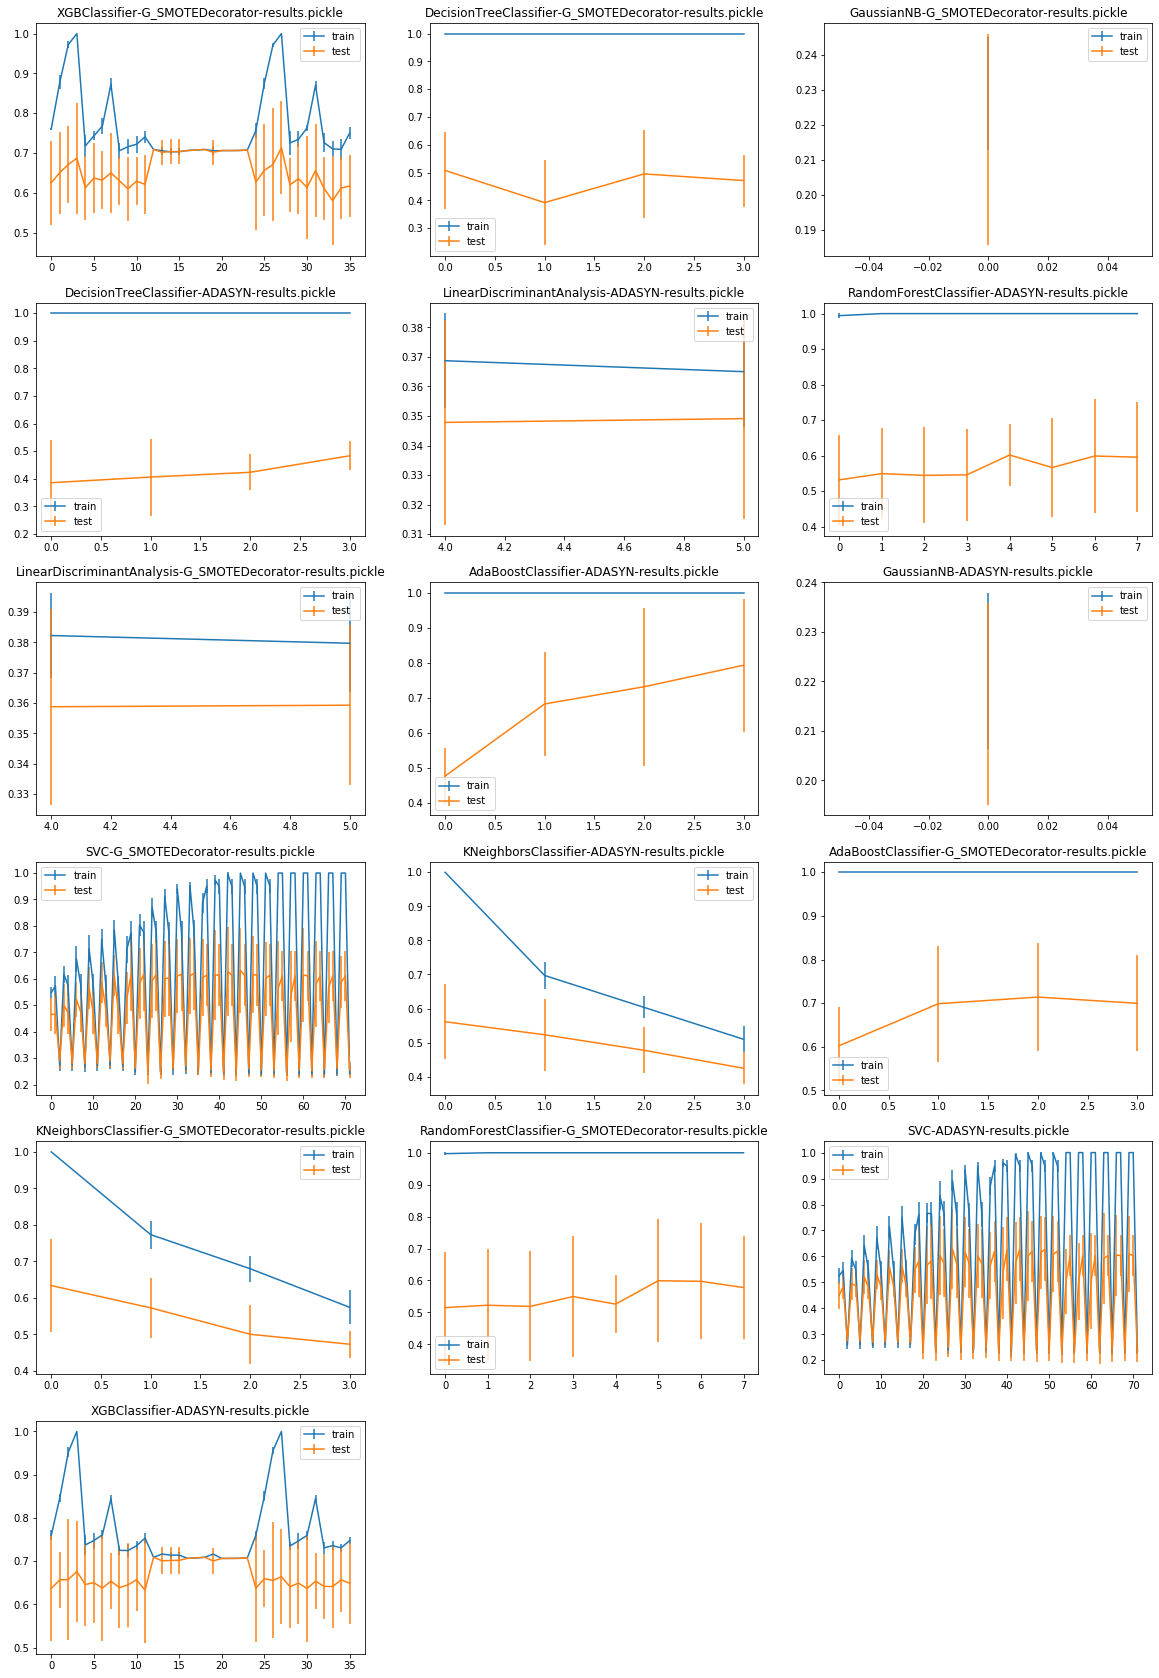

In [2]:
plt.figure(figsize=(20,30))
res_paths = glob('../model_selection/results/*results.pickle')
n_cols_plots = 3
n_rows_plots = (len(res_paths) // n_cols_plots) + 1

all_results = []

for i, path in enumerate(res_paths):
    path = Path(path)
    with open(path, 'rb') as fh:
        results, *_ = pickle.load(fh)
        
    results = pd.DataFrame(results)
    all_results.append(results)
    
    plt.subplot(n_rows_plots, n_cols_plots, i + 1)
    x = list(range(len(results)))
    plt.errorbar(x, results.mean_train_score, results.std_train_score, label='train')
    plt.errorbar(x, results.mean_test_score, results.std_test_score, label='test')
    plt.legend()
    plt.title(path.name)

In [3]:
best_result = 0
best_method = None

for result in all_results:
    res = max(result.mean_test_score)
    if res > best_result:
        best_result = res
        best_method = result.columns
print(best_method, best_result)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_AdaBoostClassifier__base_estimator',
       'param_AdaBoostClassifier__n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object') 0.7928571428571429


## Baseline

Using TensorFlow backend.
2019-12-08 11:25:51,097:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}")
2019-12-08 11:25:51,789:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}")
2019-12-08 11:25:54,320:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}")
2019-12-08 11:25:54,905:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}")
2019-12-08 11:25:56,430:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}")
2019-12-08 11:25:57,014:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs':

0.7010692075247663


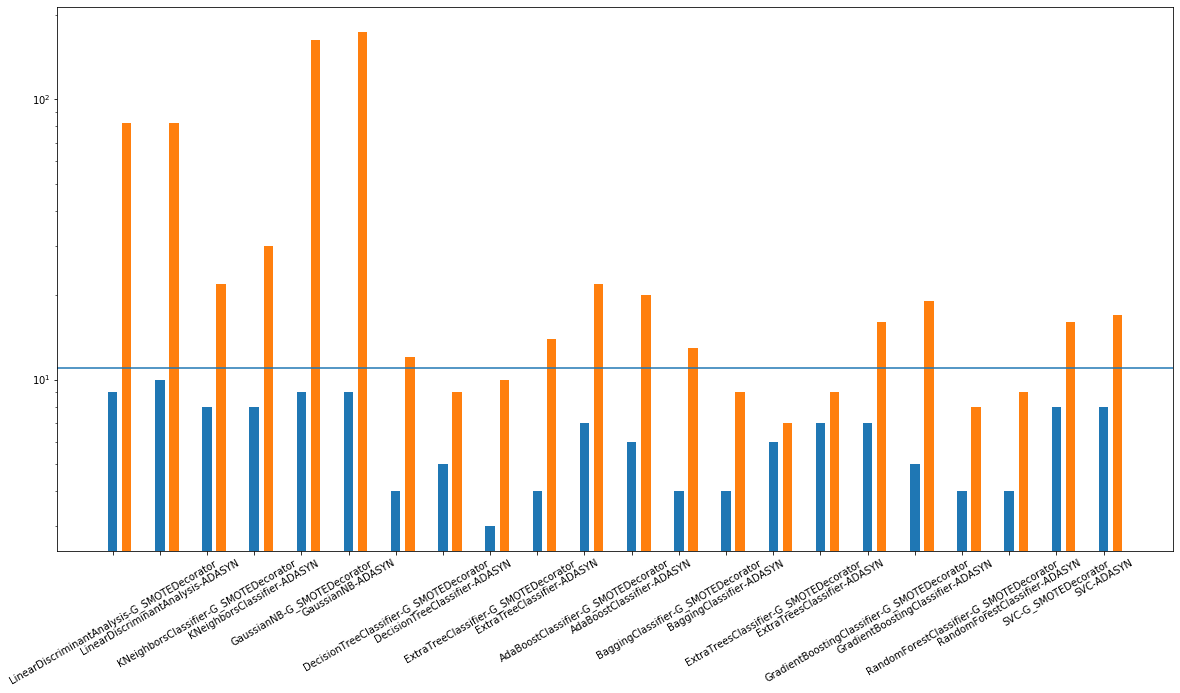

In [4]:
from src.evaluation import imbalanced_score, matthews_corrcoef_score

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier, RandomForestClassifier)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from src.oversampling import G_SMOTEDecorator

from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
models = [
    LinearDiscriminantAnalysis, KNeighborsClassifier, GaussianNB,
    DecisionTreeClassifier, ExtraTreeClassifier, AdaBoostClassifier, BaggingClassifier,
    ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, SVC
]

X = pd.read_csv('../data/all_X.csv')
y = pd.read_csv('../data/all_y.csv', header=None).T.ix[0]

i_train, i_test = next(StratifiedShuffleSplit(test_size=0.2, random_state=40).split(X, y))

X_train, X_test, y_train, y_test = X.loc[i_train], X.loc[i_test], y.loc[i_train], y.loc[i_test]

tps, ts, gts, labels, scores = [], [], [], [], []
for Model in models:
    for oversampler in [G_SMOTEDecorator(), ADASYN()]:
        pipeline = Pipeline([
            ('OVERSAMPLER', oversampler), (Model.__name__, Model())
        ])
        clf = pipeline.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        tps.append(sum(y_test & y_pred))
        ts.append(sum(y_pred))
        gts.append(sum(y_test))
        labels.append(f'{Model.__name__}-{oversampler.__class__.__name__}')
        scores.append(imbalanced_score(0.7(clf, X_test, y_test))

plt.figure(figsize=(20,10))
x = np.arange(len(tps))

plt.bar(x, tps, width=0.2)
plt.bar(x + 0.3, ts, width=0.2)

plt.xticks(x, labels, rotation=30)
plt.yscale('log')
plt.axhline(gts[0])
print(max(scores))

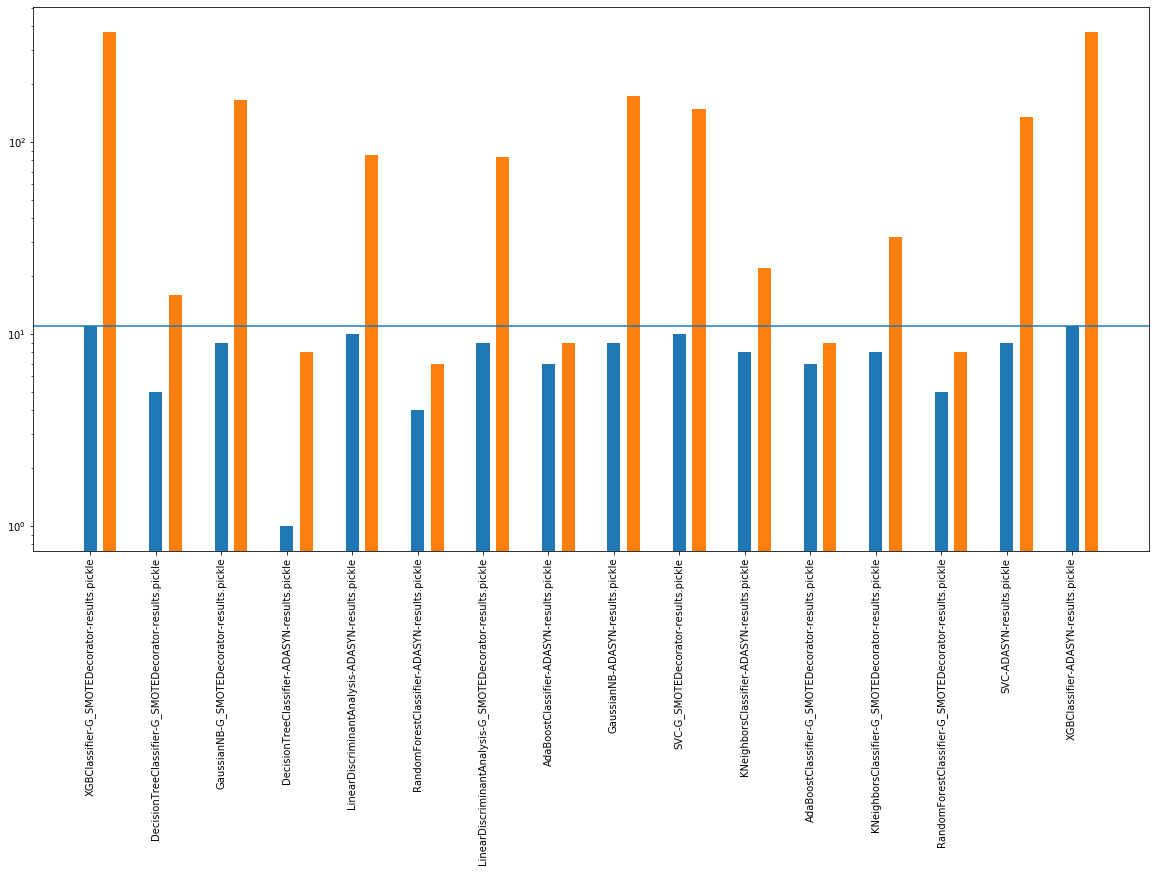

In [13]:
res_paths = glob('../model_selection/results/*results.pickle')
n_cols_plots = 3
n_rows_plots = (len(res_paths) // n_cols_plots) + 1

tps, ts, gts, labels = [], [], [], []
for i, path in enumerate(res_paths):
    path = Path(path)
    with open(path, 'rb') as fh:
        _, y_true, y_pred = pickle.load(fh)
    tps.append(sum(y_true & y_pred))
    ts.append(sum(y_pred))
    gts.append(sum(y_true))
    labels.append(path.name)

plt.figure(figsize=(20,10))
x = np.arange(len(tps))

plt.bar(x, tps, width=0.2)
plt.bar(x + 0.3, ts, width=0.2)

plt.xticks(x, labels, rotation=90)
plt.yscale('log')
plt.axhline(gts[0])

In [8]:
res_paths = glob('../model_selection/results/*.pickle')

for i, path in enumerate(res_paths):
    path = Path(path)
    if 'results' in path.name: continue
    with open(path, 'rb') as fh:
        conf = pickle.load(fh)
    print(conf)

{'SVC__C': 1, 'SVC__degree': 5, 'SVC__kernel': 'poly'}
{'LinearDiscriminantAnalysis__shrinkage': 'auto', 'LinearDiscriminantAnalysis__solver': 'eigen'}
{'DecisionTreeClassifier__criterion': 'entropy', 'DecisionTreeClassifier__splitter': 'random'}
{'XGBClassifier__booster': 'dart', 'XGBClassifier__learning_rate': 0.1, 'XGBClassifier__n_estimators': 500}
{'DecisionTreeClassifier__criterion': 'gini', 'DecisionTreeClassifier__splitter': 'best'}
{'XGBClassifier__booster': 'dart', 'XGBClassifier__learning_rate': 0.1, 'XGBClassifier__n_estimators': 500}
{'AdaBoostClassifier__base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, s